In [ ]:
# # MSc Project: Multi-Label Classification
# ### Part 1: Cell 1 - Setup & Imports  ###
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
import torch
import evaluate

print(" Cell 1/4: All libraries imported successfully.")

/home/ubuntu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


 Cell 1/4: All libraries imported successfully.


In [ ]:
# Part 2: Cell 2 - Kaggle Data Preprocessing 
print("\n Cell 2/4: Starting Kaggle data loading and preprocessing...")

print("Loading 'Kaggle_ML_Dataset/train.csv'...")
df = pd.read_csv('Kaggle_ML_Dataset/train.csv')

# Define the Tokenizer 
# We need to create the tokenizer before we can use its .sep_token
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
print("Tokenizer loaded.")

# Combine TITLE and ABSTRACT for better model context ---
df['text'] = df['TITLE'] + tokenizer.sep_token + df['ABSTRACT']
print("Combined TITLE and ABSTRACT into a single 'text' column.")

#  Define the multi-label task 
# Label columns from the train.csv from Kaggle
target_labels = ['Computer Science', 'Physics', 'Mathematics', 'Statistics', 'Quantitative Biology', 'Quantitative Finance']
label2id = {label: i for i, label in enumerate(target_labels)}
id2label = {i: label for i, label in enumerate(target_labels)}
num_labels = len(target_labels)

print(f"\nDefined a {num_labels}-way multi-label task with categories: {target_labels}")

# --- Convert Pandas DataFrame to a Hugging Face Dataset object ---
hg_dataset = Dataset.from_pandas(df)

# --- Preprocessing Function ---
def preprocess_function(examples):
    # Tokenize the combined text field
    tokenized_inputs = tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)
    
    # Gather the one-hot encoded labels into a list of floats
    labels = [float(examples[label]) for label in target_labels]
    tokenized_inputs["labels"] = labels
    
    return tokenized_inputs

print("\nPreprocessing and tokenizing the dataset...")
processed_dataset = hg_dataset.map(preprocess_function, remove_columns=df.columns.tolist())

print(f"Finished preprocessing. Total documents for our task: {len(processed_dataset)}")
print(" Cell 2/4: Data preprocessing complete.")


 Cell 2/4: Starting Kaggle data loading and preprocessing...
Loading 'Kaggle_ML_Dataset/train.csv'...
Tokenizer loaded.
Combined TITLE and ABSTRACT into a single 'text' column.

Defined a 6-way multi-label task with categories: ['Computer Science', 'Physics', 'Mathematics', 'Statistics', 'Quantitative Biology', 'Quantitative Finance']

Preprocessing and tokenizing the dataset...


Map: 100%|████████████████████████| 20972/20972 [00:27<00:00, 766.98 examples/s]

Finished preprocessing. Total documents for our task: 20972
 Cell 2/4: Data preprocessing complete.


In [ ]:
# ### Part 3: Cell 3 - Data Splitting & Model Configuration ###
print("\n Cell 3/4: Splitting data and configuring the model...")

# --- Import scikit-learn metrics ---
from sklearn.metrics import f1_score, accuracy_score

# Split the dataset into training and testing sets (80/20 split)
train_test_split_dataset = processed_dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = train_test_split_dataset['train']
test_dataset = train_test_split_dataset['test']
print(f"Split into {len(train_dataset)} training and {len(test_dataset)} testing documents.")

# Load the model with a multi-label classification head
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    problem_type="multi_label_classification",
    id2label=id2label,
    label2id=label2id
)

# Using the scikit-learn metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(logits))
    predictions = np.zeros(probs.shape)
    predictions[np.where(probs >= 0.5)] = 1
    
    y_pred = predictions.astype(int)
    y_true = labels.astype(int)
    
    f1_micro = f1_score(y_true=y_true, y_pred=y_pred, average="micro")
    accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
    
    return {"f1_micro": f1_micro, "accuracy": accuracy}

# Testing new settings
training_args = TrainingArguments(
    output_dir="./results_multilabel",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    logging_steps=250,
    eval_strategy="steps",
    eval_steps=250,
    save_steps=250,
    load_best_model_at_end=True,
    metric_for_best_model="f1_micro",
    save_total_limit=2,  # <-- change the save total limit so the script doesnt crash cause it ate too much storage again
)
print(" Cell 3/4: Model and trainer configured successfully.")


 Cell 3/4: Splitting data and configuring the model...
Split into 16777 training and 4195 testing documents.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 Cell 3/4: Model and trainer configured successfully.


In [ ]:
# ### Part 4: Cell 4 - Train and Evaluate  ###
print("\n Cell 4/4: Creating the Trainer object and starting the final run...")
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

# Train model
print("\nStarting final model training... This is the one.")
trainer.train()
print("\nTraining finished")

print("\nRunning final evaluation...")
evaluation_results = trainer.evaluate()
print("\nEvaluation complete!")
print("This is our final, definitive multi-label performance score:")
print(evaluation_results)
print("\n Cell 4/4: Workflow complete.")

/tmp/ipykernel_11562/223063524.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



 Cell 4/4: Creating the Trainer object and starting the final run...

Starting final model training... This is the one.


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss,Validation Loss,F1 Micro,Accuracy
250,0.284300,0.228102,0.778266,0.634088
500,0.217200,0.212989,0.786646,0.624791
750,0.212500,0.198806,0.807410,0.645054
1000,0.190600,0.200080,0.793628,0.664839
1250,0.183100,0.176151,0.823609,0.679857
1500,0.178900,0.180181,0.818410,0.671752
1750,0.187500,0.171874,0.829494,0.682241
2000,0.184700,0.175254,0.827079,0.695352
2250,0.163700,0.177276,0.828801,0.700358
2500,0.150300,0.182898,0.829861,0.678427


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader

In [7]:
# Checking if it has finished since we use detach screen
# Load fully-trained model and analyze its performance.

from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import f1_score, accuracy_score, multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print(" Checking model and evaluate its performance...")

# Load the best model from the overnight run since theres only 2 
# The Trainer automatically saves the best checkpoint checkpoint subfolder
import os
output_dir = "./results_multilabel"
last_checkpoint = sorted([d for d in os.listdir(output_dir) if d.startswith("checkpoint-")])[-1]
best_model_path = os.path.join(output_dir, last_checkpoint)

print(f"Found best model at: {best_model_path}")


model = AutoModelForSequenceClassification.from_pretrained(
    best_model_path,
    num_labels=num_labels,
    problem_type="multi_label_classification",
    id2label=id2label,
    label2id=label2id
)

# Trainer object to run the evaluation
# (Using for 'predict' function)
trainer = Trainer(model=model)

print("\nModel loaded. Running final predictions on the test set... Cell 5 Ready")

# --- Get the final predictions ---
predictions_output = trainer.predict(test_dataset)
logits = predictions_output.predictions

print("Predictions complete! Cell 5 Complete!")

 Checking model and evaluate its performance...
Found best model at: ./results_multilabel/checkpoint-6294

Model loaded. Running final predictions on the test set... Cell 5 Ready


/home/ubuntu/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Predictions complete! Cell 5 Complete!



Analyzing results and building the full metrics report...

--- FINAL PERFORMANCE REPORT ---
Accuracy:           69.77%
------------------------------------
Precision (Micro):  83.14%
Recall (Micro):     84.54%
F1-Score (Micro):   83.84%
------------------------------------
Precision (Macro):  78.01%
Recall (Macro):     76.06%
F1-Score (Macro):   76.92%
------------------------------------

Generating confusion matrices for each label...


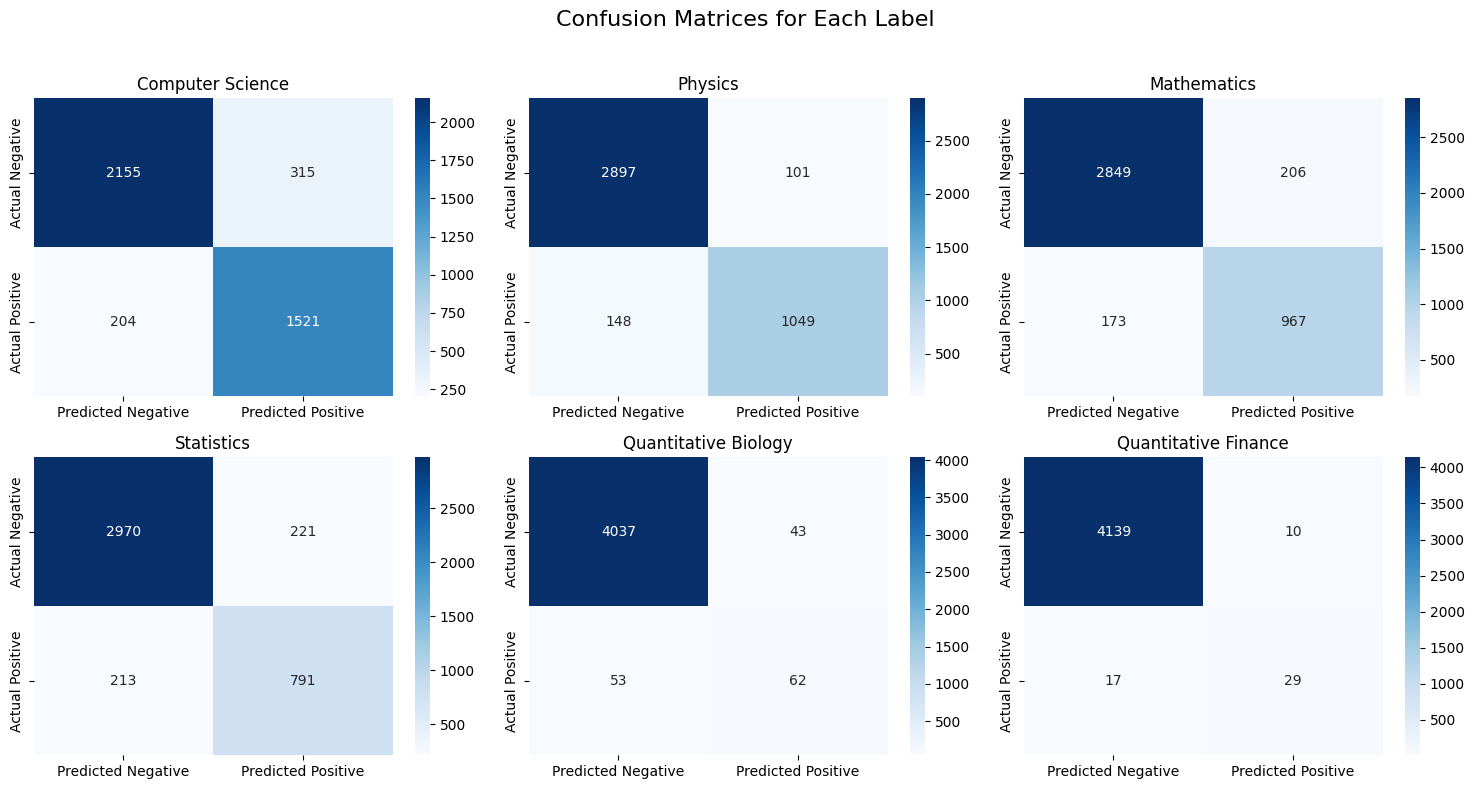


Analysis complete. This is the final deliverable for the project.


In [15]:
print("\nAnalyzing results and building the full metrics report...")

# --- Convert logits to final 0/1 predictions ---
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(torch.Tensor(logits))
final_predictions = np.zeros(probs.shape)
final_predictions[np.where(probs >= 0.5)] = 1

# --- Get the true labels ---
true_labels = np.array(test_dataset['labels'])

# --- Calculate all metric ---
# calculate "micro" (which is overall) and "macro" (per-class average)

# Accuracy (this one is just one number)
accuracy = accuracy_score(y_true=true_labels, y_pred=final_predictions)

# Precision
precision_micro = precision_score(y_true=true_labels, y_pred=final_predictions, average='micro')
precision_macro = precision_score(y_true=true_labels, y_pred=final_predictions, average='macro')

# Recall
recall_micro = recall_score(y_true=true_labels, y_pred=final_predictions, average='micro')
recall_macro = recall_score(y_true=true_labels, y_pred=final_predictions, average='macro')

# F1-Score
f1_micro = f1_score(y_true=true_labels, y_pred=final_predictions, average='micro')
f1_macro = f1_score(y_true=true_labels, y_pred=final_predictions, average='macro')


# --- Print all the results from above ---
print("\n--- FINAL PERFORMANCE REPORT ---")
print(f"Accuracy:           {accuracy*100:.2f}%")
print("------------------------------------")
print(f"Precision (Micro):  {precision_micro*100:.2f}%")
print(f"Recall (Micro):     {recall_micro*100:.2f}%")
print(f"F1-Score (Micro):   {f1_micro*100:.2f}%")
print("------------------------------------")
print(f"Precision (Macro):  {precision_macro*100:.2f}%")
print(f"Recall (Macro):     {recall_macro*100:.2f}%")
print(f"F1-Score (Macro):   {f1_macro*100:.2f}%")
print("------------------------------------")


# --- Generate the Confusion Matrices ---
print("\nGenerating confusion matrices for each label...")
conf_matrices = multilabel_confusion_matrix(y_true=true_labels, y_pred=final_predictions)

# --- Plotting the graphs ---
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('Confusion Matrices for Each Label', fontsize=16)

for i, matrix in enumerate(conf_matrices):
    label = id2label[i]
    ax = axes.flatten()[i]
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Predicted Negative', 'Predicted Positive'], 
                yticklabels=['Actual Negative', 'Actual Positive']      
               ) 
    ax.set_title(label)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

print("\nAnalysis complete. This is the final deliverable for the project.")